In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [3]:
#creates an object_point matrix with a given array of checkerboard sizes f.e. [(7,5),(10,15),(2,3)] 
def generate_objp_matrix(cb_matrix):
    objp_matrix = []
    for cb in cb_matrix:
        nb_horizontal = cb[1]
        nb_vertical = cb[0]
        objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
        objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)
        objp_matrix.append(objp)
    return objp_matrix

In [4]:
#returns an image where checkerboards are hidden with a rectangle between upper-left and lower-right corners given on imgpoints.
def hide_cb(img,img_points,margin=0):
    for corners in img_points:
        cornerx=[]
        cornery=[]
        for corner in corners:
            cornerx.append(corner[0][0])
            cornery.append(corner[0][1])
        cornerx = np.array(cornerx)
        cornery = np.array(cornery)
        cv2.rectangle(img,(int(cornerx.min()-margin),int(cornery.min()-margin)),(int(cornerx.max()+margin),int(cornery.max()+margin)),(255,255,255),-1)
    return img

In [36]:
#finds the obj_points and img_points of the different checkerboards in a given image
def find_img_points(img_path,cb_matrix,margin=0):
    objp_matrix = generate_objp_matrix(cb_matrix)#create the objp_matrix
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    n = 0
    img = cv2.imread(img_path)
    for cb in cb_matrix: 
        ret=True
        while(ret==True):
            img = hide_cb(img,imgpoints)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, cb)
            if ret == True:
                objpoints.append(objp_matrix[n])
                imgpoints.append(corners)
                # Draw and display the corners to see the process(optional)
                img = cv2.drawChessboardCorners(img, cb, corners,ret)
                ###########################################################
                cv2.imshow('img',img)
                cv2.waitKey(300)
        n=n+1
    cv2.waitKey(1000)
    cv2.destroyAllWindows()
    return objpoints,imgpoints
        

In [35]:
def obtain_calib_parameters(img_path,calib_path,cb_matrix,margin=0):
    images = glob.glob(img_path)
    assert images
    combined_objp=[]
    combined_imgp=[]
    for image in images:
        objpoints,imgpoints = find_img_points(image,cb_matrix)
        combined_objp.extend(objpoints)
        combined_imgp.extend(imgpoints)

    #get dist and new cam matrix
    img = cv2.imread(images[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detected_targets = hide_cb(img,combined_imgp,margin)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(combined_objp, combined_imgp, gray.shape[::-1], None, None)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

    #Plot results
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
    ax[0].imshow(detected_targets)
    ax[0].set_title('Detected Targets')
    ax[1].imshow(dst[...,[2,1,0]])
    ax[1].set_title('Undistorted image')

    #save dst parameters
    np.savez(
        f"{calib_path}/CalibParams",
        mtx = mtx,
        dist = dist,
        newcameramtx = newcameramtx,
        roi = roi
    )

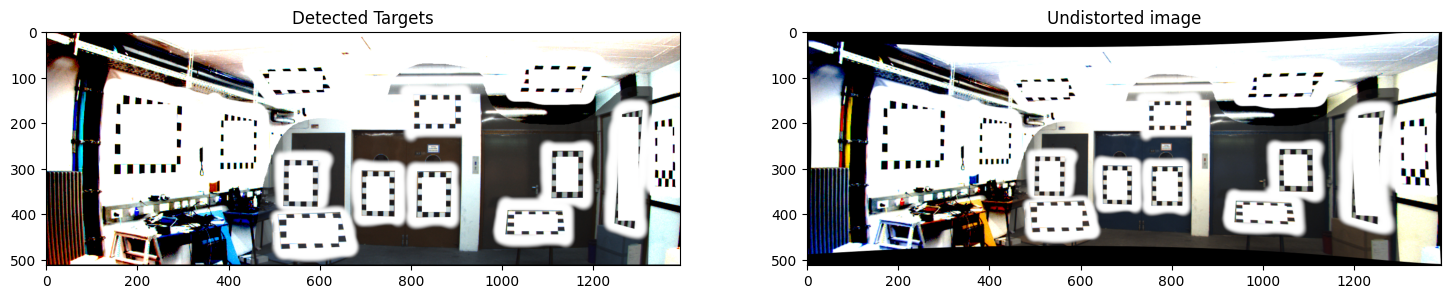

In [28]:
img_path = 'final_project/calib/image_02/data_processed/*.png'
calib_path = 'final_project/calib/camera_param/Camera2'
cb_matrix = [(15,5),(7,11),(5,7),(6,5)]
obtain_calib_parameters(img_path,calib_path,cb_matrix,margin=0)